## Random Forest Playground

Outline

1. Generate data of specific functions
2. Fit the functions using ensemble methods
3. Analyze the trees

In [145]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2, mutual_info_regression
from sklearn.pipeline import Pipeline
import sklearn.tree as _tree

In [45]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
import seaborn as sns

In [15]:
import numpy as np
from random import random

In [130]:
from joblib import dump, load


## Model

### Components

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(1000, 4000, 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(10, 30, 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 20, 30, 40, 50]
# Method of selecting samples for training each tree
bootstrap = [True, False]


rf_random_grid = {
    'rf__n_estimators': n_estimators,
    'rf__max_features': max_features,
    'rf__max_depth': max_depth,
    'rf__min_samples_split': min_samples_split,
    'rf__min_samples_leaf': min_samples_leaf,
    'rf__bootstrap': bootstrap
}

rf = RandomForestRegressor(random_state=42, oob_score=True)

##########

pipeline_steps = [
    ('rf', rf),
]

pipeline = Pipeline(pipeline_steps)


### Data without Noise

In [ ]:
X_sin = [[6*random()] for i in range(10000)]
y_sin = np.sin(X_sin)

X_sin_test = [[6*random()] for i in range(10000)]
y_sin_test = np.sin(X_sin_test)


In [54]:

model = RandomizedSearchCV(
    pipeline,
    cv=10,
    param_distributions = rf_random_grid,
    verbose=3,
    n_jobs=-1
)

In [55]:
model.fit(X_sin, y_sin)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
/Users/leima/anaconda/envs/mini-code/lib/python3.8/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('rf',
                                              RandomForestRegressor(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                                    criterion='mse',
                                                                    max_depth=None,
                                                                    max_features='auto',
                                                                    max_leaf_nodes=None,
                                                                    max_samples=None,
                                                                    min_impurity_decrease=0.0,
                                                                    min_impurity_split=None,
                                                                  

In [56]:
model.score(X_sin, y_sin)

0.9999470645342253

In [57]:
model.best_params_

{'rf__n_estimators': 1600,
 'rf__min_samples_split': 0.001,
 'rf__min_samples_leaf': 30,
 'rf__max_features': 'auto',
 'rf__max_depth': 10,
 'rf__bootstrap': True}

In [131]:
dump(model, 'reports/rf_sin.joblib') 

['reports/rf_sin.joblib']

Plot out the result

Text(0.5, 1.0, 'Random Forest on Sin Data; Test $R^2$ Score: 1.00')

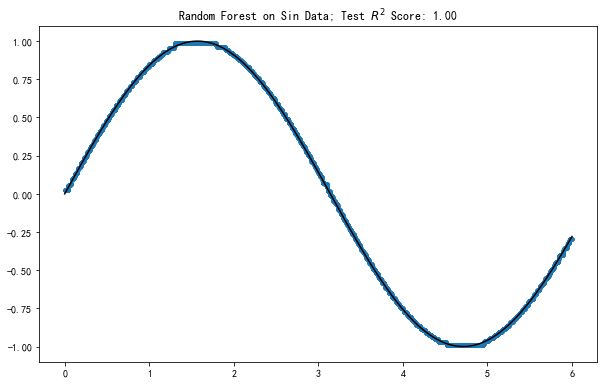

In [80]:
fig, ax = plt.subplots(figsize=(10,6.18))

ax.plot(
    X_sin_test,
    model.predict(X_sin_test),
    '.'
)
ax.plot(
    [y for y,_ in sorted(zip(X_sin_test, y_sin_test))],
    [x for _,x in sorted(zip(X_sin_test, y_sin_test))],
    'k-'
)

ax.set_title(f'Random Forest on Sin Data; Test $R^2$ Score: {model.score(X_sin_test, y_sin_test):0.2f}')

In [358]:
X_sin_est = sorted(X_sin_test)[::500]
y_sin_est_pred = []
for i in X_sin_est:
    i_y_sin_est_pred = []
    for est in model.best_estimator_['rf'].estimators_:
        i_y_sin_est_pred.append(
            est.predict([i]).tolist()
        )
    i_y_sin_est_pred = sum(i_y_sin_est_pred, [])
    y_sin_est_pred.append(i_y_sin_est_pred)

In [359]:
y_sin_est_pred_boxsize = []
for i in y_sin_est_pred:
    y_sin_est_pred_boxsize.append(np.percentile(i, 75) - np.percentile(i, 25))

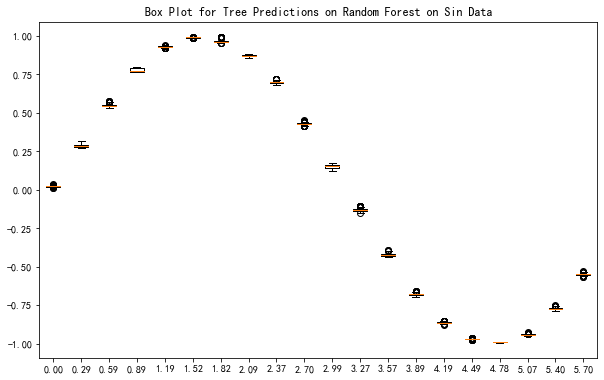

In [367]:
fig, ax = plt.subplots(figsize=(10,6.18))

ax.boxplot(
    y_sin_est_pred
)

ax.set_xticklabels(
    [f'{i:0.2f}' for i in sum(X_sin_est,[])]
)


ax.set_title('Box Plot for Tree Predictions on Random Forest on Sin Data');


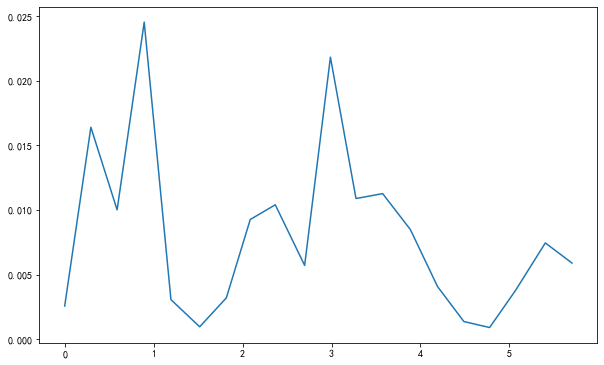

In [368]:
fig, ax = plt.subplots(figsize=(10,6.18))

ax.plot(
    X_sin_est,
    y_sin_est_pred_boxsize
);

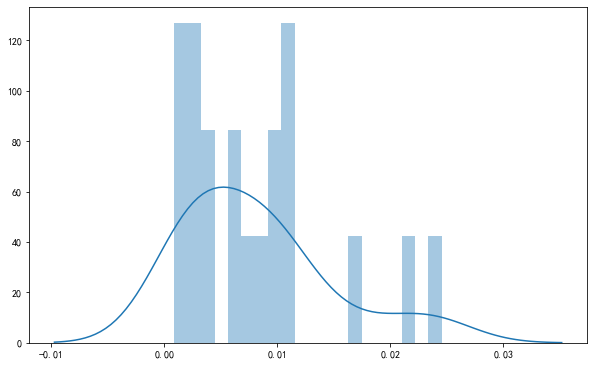

In [370]:
fig, ax = plt.subplots(figsize=(10,6.18))
sns.distplot(
    y_sin_est_pred_boxsize,
    bins=20,
    ax=ax
)

### Data with Noise

In [ ]:

X_sin_noise = [[6*random()] for i in range(10000)]
y_sin_noise = [i * (1 + 0.1*(random()-0.5)) for i in np.sin(X_sin)]

X_sin_noise_test = [[6*random()] for i in range(10000)]
y_sin_noise_test = [i * (1 + 0.1*(random()-0.5)) for i in np.sin(X_sin_noise_test)]

In [117]:
model_noise = RandomizedSearchCV(
    pipeline,
    cv=10,
    param_distributions = rf_random_grid,
    verbose=3,
    n_jobs=-1
)

In [118]:
model_noise.fit(X_sin_noise, y_sin_noise)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.2min finished
/Users/leima/anaconda/envs/mini-code/lib/python3.8/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('rf',
                                              RandomForestRegressor(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                                    criterion='mse',
                                                                    max_depth=None,
                                                                    max_features='auto',
                                                                    max_leaf_nodes=None,
                                                                    max_samples=None,
                                                                    min_impurity_decrease=0.0,
                                                                    min_impurity_split=None,
                                                                  

In [119]:
model_noise.score(X_sin, y_sin)

-0.034076931063944604

In [120]:
model_noise.best_params_

{'rf__n_estimators': 1300,
 'rf__min_samples_split': 0.2,
 'rf__min_samples_leaf': 30,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 10,
 'rf__bootstrap': True}

In [132]:
dump(model_noise, 'reports/rf_sin_noise.joblib') 

['reports/rf_sin_noise.joblib']

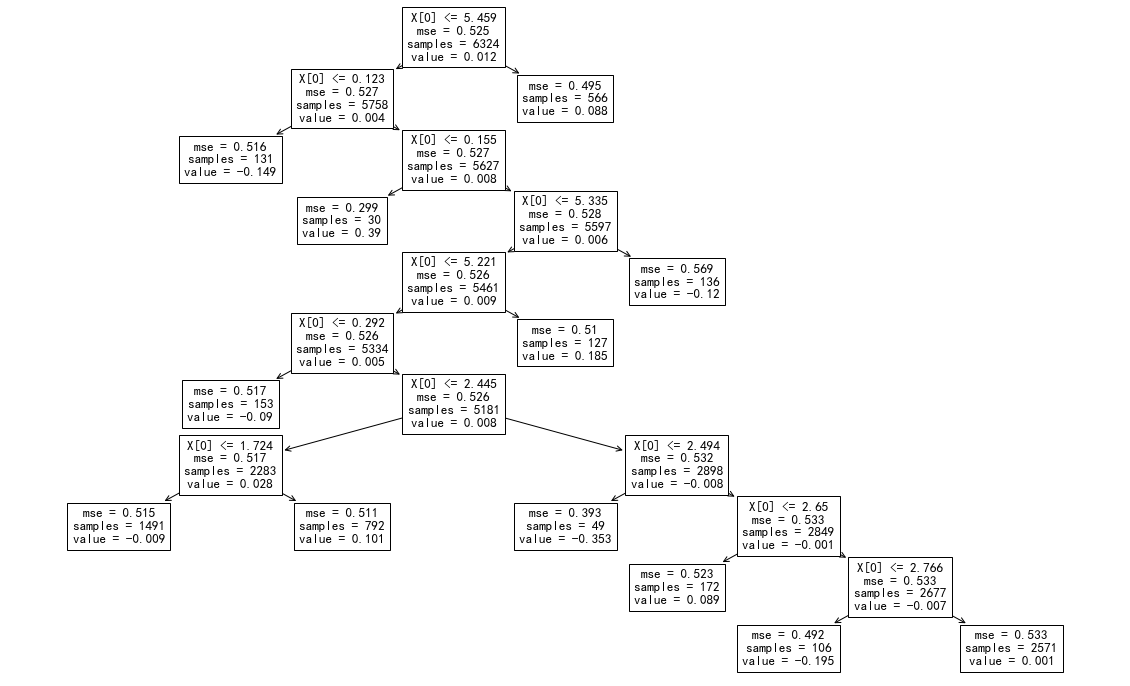

In [203]:
fig, ax = plt.subplots(figsize=(2*10, 2*6.18))
_tree.plot_tree(
    model_noise.best_estimator_['rf'].estimators_[0]
);

Text(0.5, 1.0, 'Random Forest on Sin Data with Noise; Test $R^2$ Score: 1.00')

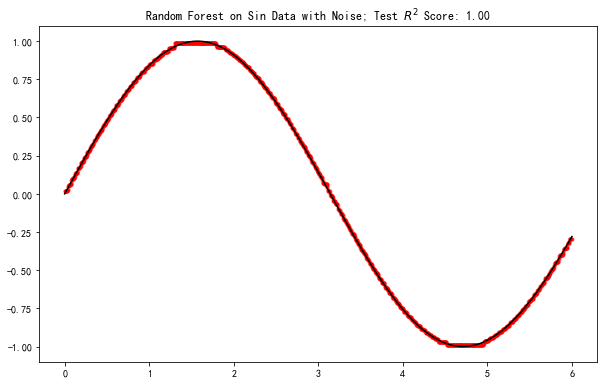

In [129]:
fig, ax = plt.subplots(figsize=(10,6.18))


ax.plot(
    X_sin_noise_test,
    model.predict(X_sin_noise_test),
    'r.', alpha=0.1
)

ax.plot(
    np.linspace(0,6,100),
    np.sin(np.linspace(0,6,100)),
    'k-'
)

ax.set_title(f'Random Forest on Sin Data with Noise; Test $R^2$ Score: {model.score(X_sin_noise_test, y_sin_noise_test):0.2f}')

In [207]:
X_sin_noise_est = sorted(X_sin_noise_test[::100])
y_sin_noise_est_pred = []

for i in X_sin_noise_est:
    i_y_sin_noise_est_pred = []
    for est in model.best_estimator_['rf'].estimators_:
        i_y_sin_noise_est_pred.append(
            est.predict([i]).tolist()
        )
    i_y_sin_noise_est_pred = sum(i_y_sin_noise_est_pred, [])
    y_sin_noise_est_pred.append(i_y_sin_noise_est_pred)

In [209]:
y_sin_noise_est_pred_boxsize = []
for i in y_sin_noise_est_pred:
    y_sin_noise_est_pred_boxsize.append(np.percentile(i, 75) - np.percentile(i, 25))

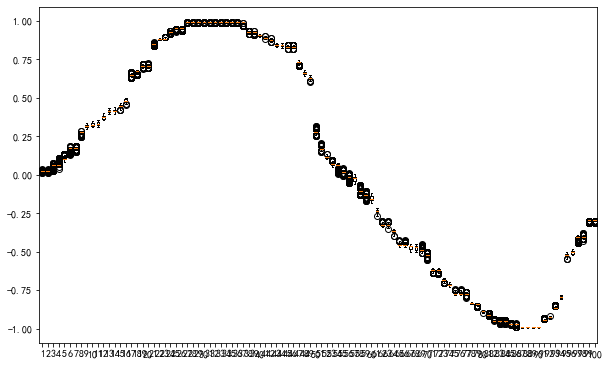

In [211]:
fig, ax = plt.subplots(figsize=(10,6.18))

ax.boxplot(
    y_sin_noise_est_pred
);

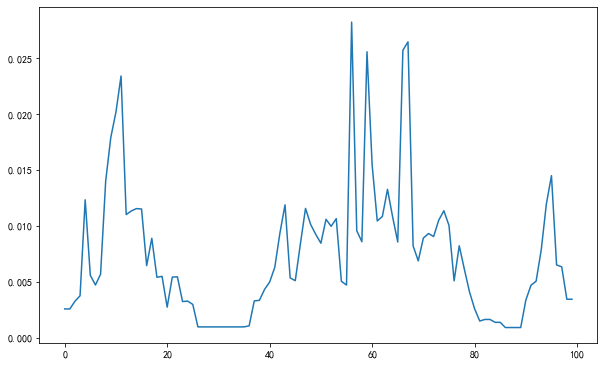

In [212]:
fig, ax = plt.subplots(figsize=(10,6.18))

ax.plot(
    y_sin_noise_est_pred_boxsize
);

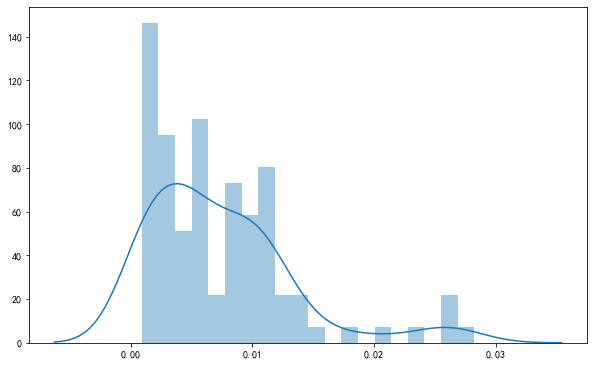

In [215]:
fig, ax = plt.subplots(figsize=(10,6.18))

sns.distplot(
    y_sin_noise_est_pred_boxsize,
    bins=20,
    ax=ax
)

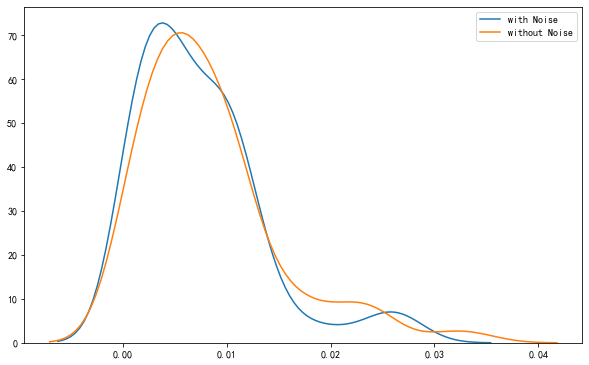

In [219]:
fig, ax = plt.subplots(figsize=(10,6.18))

sns.distplot(
    y_sin_noise_est_pred_boxsize,
    bins=20,
    ax=ax,
    hist=False,
    label='with Noise'
)

sns.distplot(
    y_sin_est_pred_boxsize,
    bins=20,
    ax=ax,
    hist=False,
    label='without Noise'
)


## Generalization Error

$$
P_{err} \leq \frac{\bar \rho (1-s^2) }{s^2}.
$$

In [298]:
def generalization_error(rhob, s):
    
    res = rhob * (1-s**2)/s**2
    
    if res >1:
        res = 1
    
    return res

In [299]:
generalization_error(0.2, 0.8)

0.11249999999999995

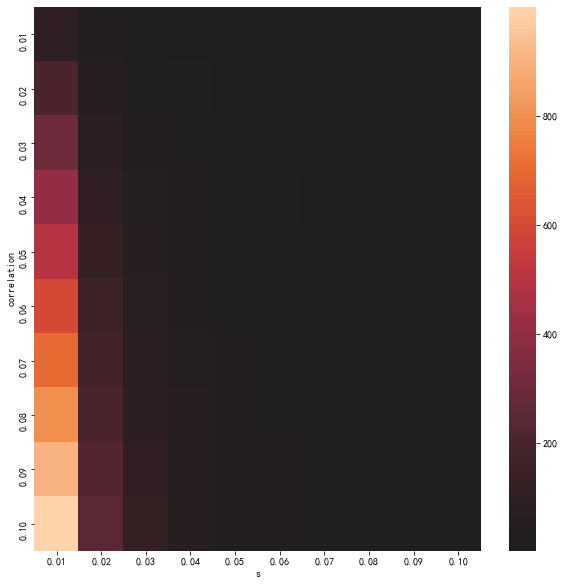

In [253]:
pe_data = [
    [
        generalization_error(rhob, s) for s in np.linspace(0.01,0.1,10)
    ] for rhob in np.linspace(0.01,0.1,10)
]

pe_data_s_label = [
        s for s in np.linspace(0.01,0.1,10)
    ]

pe_data_rhob_label =  [
    rhob for rhob in np.linspace(0.01,0.1,10)
]

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(pe_data, center=0, ax=ax)

ax.set_xlabel('s')
ax.set_ylabel('correlation')
ax.set_xticklabels(
    [f'{i:0.2f}' for i in pe_data_s_label]
)
ax.set_yticklabels(
    [f'{i:0.2f}' for i in pe_data_rhob_label]
);

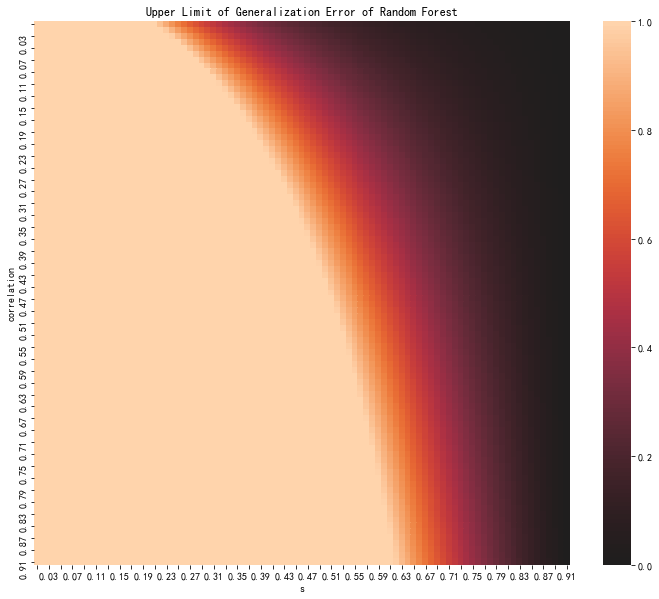

In [371]:
temp_space = np.linspace(0.1, 1, 91)

pe_data = [
    [
        generalization_error(rhob, s) for s in temp_space
    ] for rhob in temp_space
]

pe_data_s_label = [
        s for s in temp_space
    ]

pe_data_rhob_label =  [
    rhob for rhob in temp_space
]

fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(pe_data, center=0, ax=ax)

ax.set_xlabel('s')
ax.set_ylabel('correlation')

ax.set_xticklabels(
    [f'{i:0.2f}' for i in (ax.get_xticks() + 0.1)/100]
)
ax.set_yticklabels(
    [f'{i:0.2f}' for i in (ax.get_yticks() + 0.1)/100]
)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

    
ax.set_title('Upper Limit of Generalization Error of Random Forest');